In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.metrics import Precision, Recall , AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import shutil
import random

2025-05-21 07:47:55.651097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747813675.846141      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747813675.900841      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64
EPOCHS = 20
NUM_CLASSES = 3
class_names = ['Lung_Opacity', 'Normal', 'Pneumonia']
class_sizes = {'Lung_Opacity': 6012 , 'Normal': 10192, 'Pneumonia': 5929}
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

In [3]:
ORIGINAL_DATASET_DIR = "/kaggle/input/cnnmodel/data"
BASE_DIR = "/kaggle/working/dataset_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [4]:
def split_dataset():
    if os.path.exists(BASE_DIR):
        try:
            shutil.rmtree(BASE_DIR)
            print(f"Répertoire {BASE_DIR} supprimé avec succès.")
        except OSError as e:
            print(f"Erreur lors de la suppression de {BASE_DIR} : {e}")
            if e.errno != errno.ENOENT:
                raise
    else:
        print(f"Répertoire {BASE_DIR} n'existait pas, création en cours.")

    os.makedirs(BASE_DIR, exist_ok=True)

    for category in class_names:
        category_path = os.path.join(ORIGINAL_DATASET_DIR, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(VALID_EXTENSIONS)]
        random.shuffle(images)

        total = len(images)
        train_split = int(0.7 * total)
        val_split = int(0.9 * total)

        splits = {
            "train": images[:train_split],
            "validation": images[train_split:val_split],
            "test": images[val_split:]
        }

        for split_name, split_images in splits.items():
            split_path = os.path.join(BASE_DIR, split_name, category)
            os.makedirs(split_path, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(category_path, img_name)
                dst = os.path.join(split_path, img_name)
                shutil.copy(src, dst)

        print(f"Classe {category} : Train={len(splits['train'])}, Val={len(splits['validation'])}, Test={len(splits['test'])}")

    print("✅ Dataset split complete!")
    

In [5]:
split_dataset()

Répertoire /kaggle/working/dataset_split n'existait pas, création en cours.
Classe Lung_Opacity : Train=4208, Val=1202, Test=602
Classe Normal : Train=7134, Val=2038, Test=1020
Classe Pneumonia : Train=4150, Val=1186, Test=593
✅ Dataset split complete!


In [6]:
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        seed=42
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        seed=42
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        seed=42
    )

  s
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = load_data()

Found 15492 files belonging to 3 classes.


I0000 00:00:1747813926.092670      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4426 files belonging to 3 classes.
Found 2215 files belonging to 3 classes.


In [8]:
y_train_labels = []
for _, labels in train_ds.unbatch():
    y_train_labels.append(np.argmax(labels.numpy()))
y_train_labels = np.array(y_train_labels)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,845,827 (18.49 MB)

 Trainable params: 4,845,827 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0015),  
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC (name='auc')]
)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience= 3,  
    min_lr=0.0001  
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_pulmonary_disease_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


callbacks = [early_stopping, reduce_lr, checkpoint]

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


I0000 00:00:1747814019.655647      95 service.cc:148] XLA service 0x794f40011a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747814019.656366      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747814020.098976      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/243 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4219 - auc: 0.5485 - loss: 2.3155 - precision: 0.0938 - recall: 0.0469         

I0000 00:00:1747814028.668344      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6241 - auc: 0.7875 - loss: 0.9020 - precision: 0.6894 - recall: 0.4086
Epoch 1: val_loss improved from inf to 0.34194, saving model to /kaggle/working/best_pulmonary_disease_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.6246 - auc: 0.7880 - loss: 0.9008 - precision: 0.6899 - recall: 0.4096 - val_accuracy: 0.8613 - val_auc: 0.9670 - val_loss: 0.3419 - val_precision: 0.8672 - val_recall: 0.8570 - learning_rate: 0.0015
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8483 - auc: 0.9578 - loss: 0.3630 - precision: 0.8530 - recall: 0.8409
Epoch 2: val_loss improved from 0.34194 to 0.28745, saving model to /kaggle/working/best_pulmonary_disease_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8483 - auc: 0.9578 - loss: 0.3629 - precision: 0.8530 - recall: 0.8409 - val_accuracy: 0.8999 - val_auc: 0.9793 - val_loss: 0.2875 - val_precision: 0.9030 - val_recall: 0.8961 - learning

In [16]:
# Test evaluation
test_metrics = model.evaluate(test_ds, verbose=0, return_dict=True)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test AUC: {test_metrics['auc']:.4f}")



Test Accuracy: 0.9418
Test Precision: 0.9418
Test Recall: 0.9418
Test Loss: 0.1603
Test AUC: 0.9919


In [17]:
y_pred = []
y_test = []
for images, labels in test_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_pred.append(np.argmax(pred, axis=1)[0])
    y_test.append(np.argmax(labels.numpy()))
y_pred = np.array(y_pred)
y_test = np.array(y_test)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

Lung_Opacity       0.90      0.89      0.89       602
      Normal       0.93      0.94      0.94      1020
   Pneumonia       1.00      0.99      1.00       593

    accuracy                           0.94      2215
   macro avg       0.94      0.94      0.94      2215
weighted avg       0.94      0.94      0.94      2215



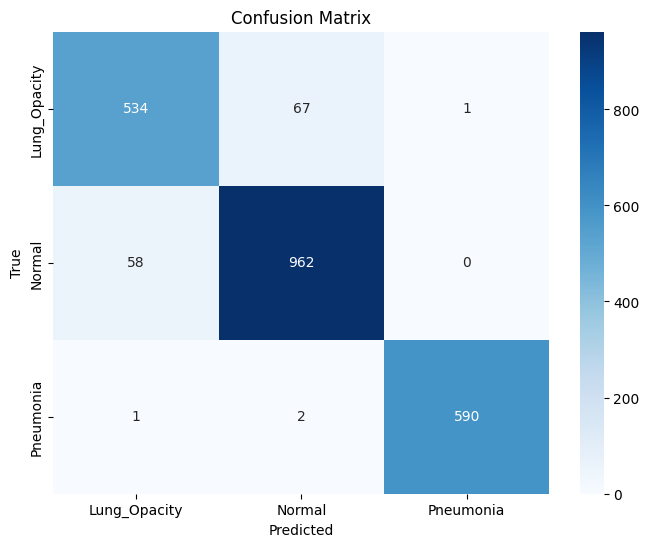

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

In [19]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

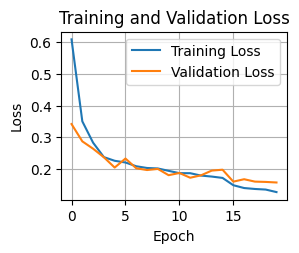

In [20]:
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss.png')

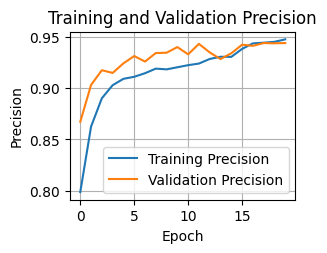

In [21]:
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

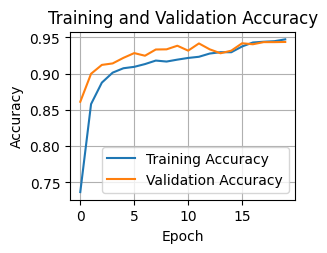

In [22]:
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy.png')

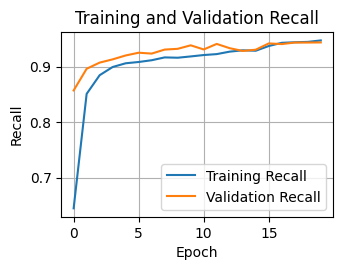

In [23]:
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In [24]:
print("\nExemple de prédictions sur l'ensemble de test:")
for i in range(5):
    print(f"Image {i+1}: Prédiction: {class_names[y_pred[i]]}, Vraie classe: {class_names[y_test[i]]}")


Exemple de prédictions sur l'ensemble de test:
Image 1: Prédiction: Normal, Vraie classe: Normal
Image 2: Prédiction: Pneumonia, Vraie classe: Pneumonia
Image 3: Prédiction: Lung_Opacity, Vraie classe: Normal
Image 4: Prédiction: Lung_Opacity, Vraie classe: Lung_Opacity
Image 5: Prédiction: Lung_Opacity, Vraie classe: Lung_Opacity
